# Problem 1: PCA and Feature Selection

## SVMs and PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import cvxopt
from tqdm.notebook import trange
from sklearn.svm import SVC

In [2]:
sonar_train = pd.read_csv('sonar_train.data', header=None)
sonar_test = pd.read_csv('sonar_test.data', header=None)
sonar_valid = pd.read_csv('sonar_valid.data', header=None)

sonar_train.loc[sonar_train[60] == 2, 60] = -1
sonar_test.loc[sonar_test[60] == 2, 60] = -1
sonar_valid.loc[sonar_valid[60] == 2, 60] = -1

def normalize(data, mean, std):
    return (data - mean) / std

def split_data(data):
    return data.iloc[:, :60].to_numpy(), data.iloc[:, 60:].to_numpy()

X, y_train = split_data(sonar_train)
train_mean = X.mean(axis=0)
print(train_mean)
train_std = X.std(axis=0)

X_train = normalize(X, train_mean, train_std)
X, y_validation = split_data(sonar_valid)
X_validation = normalize(X, train_mean, train_std)
X, y_test = split_data(sonar_test)
X_test = normalize(X, train_mean, train_std)

**Perform PCA on the training data to reduce the dimensionality of the data set (ignoring the
class labels for the moment). What are the top six eigenvalues of the data covariance matrix?**

In [3]:
def compute_covariance(norm_data):
    # Covariance matrix has dimensions (p x p)
    # Usually computed with variables as rows and observations as columns (np.cov)
    return norm_data.T.dot(norm_data)

covariance_mat = compute_covariance(X_train) #np.cov(X_train.T)

In [5]:
covariance_mat

array([[104.        ,  63.80086902,  41.0309772 , ...,  39.88264   ,
         37.45343152,  25.68642791],
       [ 63.80086902, 104.        ,  73.47996522, ...,  28.92069601,
         30.32249592,  21.5262677 ],
       [ 41.0309772 ,  73.47996522, 104.        , ...,  29.84603967,
         37.01056913,  26.1075827 ],
       ...,
       [ 39.88264   ,  28.92069601,  29.84603967, ..., 104.        ,
         54.27289429,  30.38930996],
       [ 37.45343152,  30.32249592,  37.01056913, ...,  54.27289429,
        104.        ,  60.76099161],
       [ 25.68642791,  21.5262677 ,  26.1075827 , ...,  30.38930996,
         60.76099161, 104.        ]])

In [4]:
e_val, e_vec = np.linalg.eig(covariance_mat)
i_rev = e_val.argsort()[::-1]
eig_vals = e_val[i_rev]
eig_vecs = e_vec[:, i_rev]
print("Top 6 Eigen values", eig_vals[:6])

Top 6 Eigen values [1344.02076581 1196.11970978  541.52327862  351.33131561  313.13028781
  267.04094634]


**For each k ∈ {1, 2, 3, 4, 5, 6}, project the training data into the best k dimensional subspace
(with respect to the Frobenius norm) and use the SVM with slack formulation to learn a
classifier for each c ∈ {1, 10, 100, 1000}. Report the error of the learned classifier on the
validation set for each k and c pair.**

In [5]:
C = [1, 10, 100, 1000]

In [6]:
data = {
    'k': [],
    'c': [],
    'Training Data Error': [],
    'Validation Data Error': []
}
for k in range(1,7):
    U = eig_vecs[:,:k]
    X_proj = X_train.dot(U)
    X_valid_proj = X_validation.dot(U)
    for c in C:
        data['k'].append(k)
        data['c'].append(c)
        clf = SVC(C=c, kernel='linear')
        clf.fit(X_proj, y_train.ravel())
        y_pred = clf.predict(X_proj)
        data['Training Data Error'].append(1 - np.mean(y_pred == y_train.ravel()))
        valid_pred = clf.predict(X_valid_proj)
        data['Validation Data Error'].append(1 - np.mean(valid_pred == y_validation.ravel()))

In [7]:
pd.DataFrame(data)

,k,c,Training Data Error,Validation Data Error
0,1,1,0.509615,0.461538
1,1,10,0.509615,0.461538
2,1,100,0.509615,0.461538
3,1,1000,0.509615,0.461538
4,2,1,0.432692,0.307692
5,2,10,0.432692,0.307692
6,2,100,0.432692,0.307692
7,2,1000,0.432692,0.307692
8,3,1,0.269231,0.211538
9,3,10,0.269231,0.211538


**How does it compare to the best
classifier (with the same possible c choices) without feature selection?**

In [8]:
data = {
    'c': [],
    'Training Data Error': [],
    'Validation Data Error': []
}
for c in C:
    data['c'].append(c)
    clf = SVC(C=c, kernel='linear', random_state=0)
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_train)
    data['Training Data Error'].append(1 - np.mean(y_pred == y_train.ravel()))
    valid_pred = clf.predict(X_validation)
    data['Validation Data Error'].append(1 - np.mean(valid_pred == y_validation.ravel()))
pd.DataFrame(data)

,c,Training Data Error,Validation Data Error
0,1,0.009615,0.211538
1,10,0.000000,0.230769
2,100,0.000000,0.230769
3,1000,0.000000,0.230769


**What is the error of the best k/c pair on the test data? How does it compare to the best
classifier (with the same possible c choices) without feature selection? Explain your observations.**

Best k = 3 and c = 1, 10, 100, 1000

In [9]:
U = eig_vecs[:,:3]
X_proj = X_train.dot(U)
X_test_proj = X_test.dot(U)
res = {
    'c': [],
    'Test data error': []
}
for c in [1, 10, 100, 1000]:
    res['c'].append(c)
    clf = SVC(C=c, kernel='linear', random_state=0)
    clf.fit(X_proj, y_train.ravel())
    res['Test data error'].append(1 - np.mean(clf.predict(X_test_proj) == y_test.ravel()))
pd.DataFrame.from_dict(res)

,c,Test data error
0,1,0.192308
1,10,0.192308
2,100,0.192308
3,1000,0.192308


In [10]:
# SVM without feature selection
res = {
    'c': [],
    'Test data error': []
}
for c in [1]:
    res['c'].append(c)
    clf = SVC(C=c, kernel='linear', random_state=0)
    clf.fit(X_train, y_train.ravel())
    res['Test data error'].append(1 - np.mean(clf.predict(X_test) == y_test.ravel()))
pd.DataFrame.from_dict(res)

,c,Test data error
0,1,0.211538


<span style="color:blue;font-weight:700">SVM on reduced dimension data performs better on test data compared to SVM without any feature selection</span>

**If you had to pick a value of k before evaluating the performance on the validation set (e.g.,
if this was not a supervised learning problem), how might you pick it?**

Value of k or the number of components could be picked by heuristics. We can pick the number of components needed to explain at least 85% of the data variance. For this dataset, we can pick k = 14.

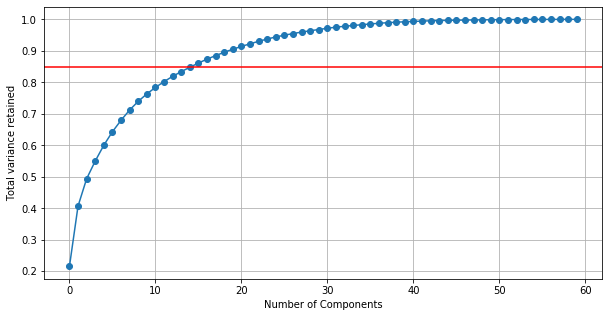

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(eig_vals) / np.sum(eig_vals), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Total variance retained')
plt.axhline(y=0.85, color='r', linestyle='-')
plt.grid()

## PCA for Feature Selection

**1. Compute the top k eigenvalues and eigenvectors of the covariance matrix corresponding to
the data matrix omitting the labels (recall that the rows of the data matrix are the input
data points).**

**2. Define π**

**3. Sample s columns independently from the probability distribution defined by π.**

In [12]:
def select_k_features(features, s, pi):
    sel_features = np.random.choice(features, s, p=pi, replace=False)
    return sel_features

**Why does π define a probability distribution?**

π has values ranging between 0 and 1. Also sum of all values in π = 1. 

**Again, using the UCI Sonar data set, for each k ∈ {1, . . . , 10} and each s ∈ {1, . . . , 20},
report the average test error of the SVM with slack classifier over 100 experiments. For each
experiment use only the s selected features (note that there may be some duplicates, so only
include each feature once).**

In [13]:
data = {
    'k': [],
    's': [],
    'Average test error': []
}
datapoints, features = X_train.shape
for k in trange(1,11):
    V = eig_vecs[:k]
    pi = np.sum(V**2, axis=0) / k
    for s in trange(1,21):
        error = []
        for _ in range(100):
            sel_features = select_k_features(features, s, pi)
            clf = SVC(C=1, kernel='linear', random_state=0)
            clf.fit(X_train[:,sel_features], y_train.ravel())
            y_pred = clf.predict(X_test[:,sel_features])
            error.append(1 - np.mean(y_pred==y_test.ravel()))
        mean_error = np.mean(error)
        data['k'].append(k)
        data['s'].append(s)
        data['Average test error'].append(mean_error)
res = pd.DataFrame.from_dict(data)

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
res

,k,s,Average test error
0,1,1,0.460769
1,1,2,0.401154
2,1,3,0.378269
3,1,4,0.367692
4,1,5,0.350192
5,1,6,0.320769
6,1,7,0.318846
7,1,8,0.318077
8,1,9,0.305192
9,1,10,0.302115


In [15]:
res.loc[res['Average test error'] == res['Average test error'].min()]

,k,s,Average test error
198,10,19,0.231154


**Does this provide a reasonable alternative to SVM with slack formulation without feature
selection on this data set? What are the pros and cons of this approach?**

SVM with feature selection (k = 7,  s = 20, c = 1) gives lowest average test error of 23% whereas SVM without feature selection  (c = 1) gives lowest test error of 21%. There is not much improvement with feature selection.

Pros:	
- Training individual models is computationally faster as number of features is less

Cons:
- Choosing k and s is difficult. Grid search like above takes long time